In [1]:
from keras.models import load_model
from keras.models import Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import multiprocessing

from utils.DomainImageGenerator import DomainImageGenerator

2025-07-25 12:21:22.960612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the Dataset as Generators so not all images are loaded into ram at the same time. The generator class loads the needed images per batch
cpu_count = multiprocessing.cpu_count()
njobs = int(cpu_count * 0.9) # Just set to use some percent of cpus
max_queue_size = 15
use_multiprocessing = True

model = load_model("../models/MinimalModelRescaledImages.keras")
test_gen = DomainImageGenerator("prepared/test.csv", batch_size=64, shuffle=False, n_jobs=njobs, use_multiprocessing=use_multiprocessing, max_queue_size=max_queue_size)

2025-07-18 16:43:29.461694: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8444 - loss: 0.5525
Test Accuracy: 0.8755
Test Loss: 0.4520


In [4]:
test_gen.set_Mode_To_Rescale(rescale=True, source=None)
test_loss_rescale, test_acc_rescale = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc_rescale:.4f}")
print(f"Test Loss: {test_loss_rescale:.4f}")
test_gen.set_Mode_To_Rescale(rescale=False)

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9399 - loss: 0.1721
Test Accuracy: 0.9523
Test Loss: 0.1439


In [5]:
# Shuffle needs to be off for this to make sense. Shuffling can be done by hand with test_gen.shuffle_indexes()

test_gen.shuffle_indexes()
y_true = test_gen.getAllLabels()
y_pred = model.predict(test_gen)

test_gen.set_Mode_To_Rescale(rescale=True, source=None)
y_pred_rescaled = model.predict(test_gen)
test_gen.set_Mode_To_Rescale(rescale=False)

y_pred_binary = (y_pred > 0.5).astype(int).flatten()
y_pred_binary_rescaled = (y_pred_rescaled > 0.5).astype(int).flatten()

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step


In [6]:
y_greater = y_pred[(y_pred > 0.5)]
predictions_greater_half = len(y_greater)

values = [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
print(f"There are {predictions_greater_half} predictions greater then 0.5")
for num in values:
    y_greater_num = y_greater[(y_greater > num)]
    print(f"\n{len(y_greater_num)} predictions are greater then {num}")
    print(f"That is {(len(y_greater_num)/predictions_greater_half) * 100:.1f} percent of all predictions greater then 0.5")

There are 81157 predictions greater then 0.5

79845 predictions are greater then 0.6
That is 98.4 percent of all predictions greater then 0.5

78472 predictions are greater then 0.7
That is 96.7 percent of all predictions greater then 0.5

76946 predictions are greater then 0.8
That is 94.8 percent of all predictions greater then 0.5

74904 predictions are greater then 0.9
That is 92.3 percent of all predictions greater then 0.5

73359 predictions are greater then 0.95
That is 90.4 percent of all predictions greater then 0.5

71453 predictions are greater then 0.98
That is 88.0 percent of all predictions greater then 0.5


In [7]:
y_less = y_pred[(y_pred < 0.5)]
predictions_less_half = len(y_less)

values = [0.4, 0.3, 0.2, 0.1, 0.05, 0.02]
print(f"There are {predictions_less_half} predictions less then 0.5")
for num in values:
    y_less_num = y_less[(y_less < num)]
    print(f"\n{len(y_less_num)} predictions are smaller then {num}")
    print(f"That is {(len(y_less_num)/predictions_less_half) * 100:.1f} percent of all predictions smaller then 0.5")

There are 8843 predictions less then 0.5

7580 predictions are smaller then 0.4
That is 85.7 percent of all predictions smaller then 0.5

6205 predictions are smaller then 0.3
That is 70.2 percent of all predictions smaller then 0.5

4720 predictions are smaller then 0.2
That is 53.4 percent of all predictions smaller then 0.5

2885 predictions are smaller then 0.1
That is 32.6 percent of all predictions smaller then 0.5

1633 predictions are smaller then 0.05
That is 18.5 percent of all predictions smaller then 0.5

716 predictions are smaller then 0.02
That is 8.1 percent of all predictions smaller then 0.5


In [8]:
print(classification_report(y_true, y_pred_binary, target_names=["CIFAR-10", "ImageNet"]))

              precision    recall  f1-score   support

    CIFAR-10       1.00      0.44      0.61     20000
    ImageNet       0.86      1.00      0.93     70000

    accuracy                           0.88     90000
   macro avg       0.93      0.72      0.77     90000
weighted avg       0.89      0.88      0.86     90000



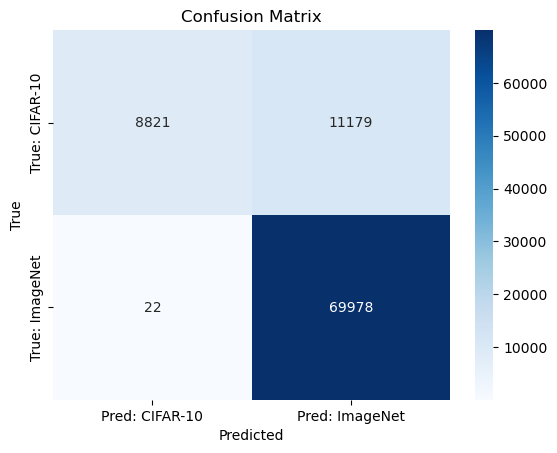

In [9]:
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: CIFAR-10", "Pred: ImageNet"],
            yticklabels=["True: CIFAR-10", "True: ImageNet"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

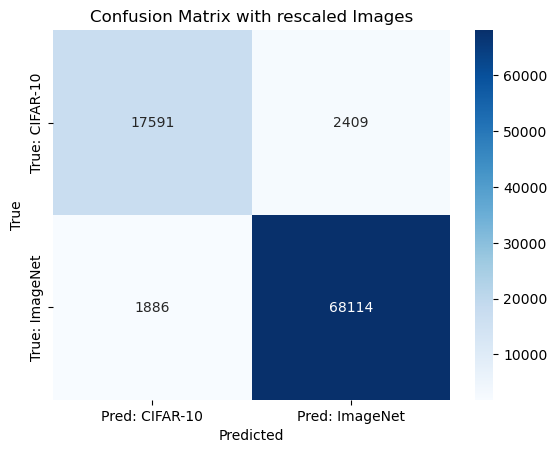

In [10]:
cm = confusion_matrix(y_true, y_pred_binary_rescaled)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: CIFAR-10", "Pred: ImageNet"],
            yticklabels=["True: CIFAR-10", "True: ImageNet"])
plt.title("Confusion Matrix with rescaled Images")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [11]:
indexes = test_gen.return_Indexes()
categories = test_gen.return_Category_by_Index(indexes)

In [12]:
# Build the DataFrame
df_images = pd.DataFrame({
    "index": indexes,
    "category": categories,
    "y_true": y_true,
    "prediction": y_pred.flatten(),
    "rescaled_prediction": y_pred_rescaled.flatten() 
})

In [13]:
df_cifar = df_images[df_images["y_true"] == 0].copy()
df_imagenet = df_images[df_images["y_true"] == 1].copy()

In [14]:
print(f"CIFAR-10: {len(df_cifar)} images")
print(f"ImageNet: {len(df_imagenet)} images")

print(df_cifar.head())
print(df_imagenet.head())

CIFAR-10: 20000 images
ImageNet: 70000 images
    index  category  y_true  prediction  rescaled_prediction
1   72169      ship       0    0.679865             0.469372
3   55716      frog       0    0.286615             0.016308
8     758  airplane       0    0.999330             0.685148
17     70  airplane       0    0.110507             0.020001
20  19655      bird       0    0.036476             0.009118
   index category  y_true  prediction  rescaled_prediction
0  34314      cat       1    0.999996             0.976370
2  66900    horse       1    0.999966             0.973391
4  26272     bird       1    0.999996             0.989404
5  30426      cat       1    0.986011             0.752205
6  24405     bird       1    1.000000             0.998953


In [15]:
print(np.unique(df_images["category"]))

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [16]:
def from_DataFrame_get_subDataFrame_of_category(df, category):
    return df[df["category"] == category]

Loading images: 100%|████████████████████████████████| 8/8 [00:00<00:00, 1404.77it/s]


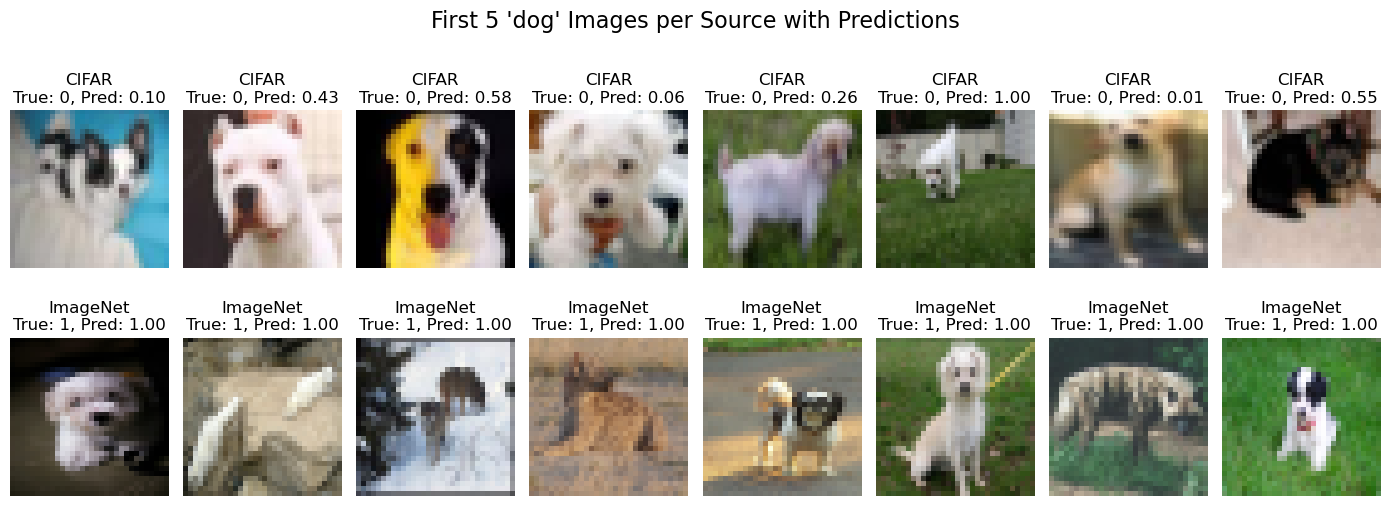

In [17]:
category = "dog"
picture_count = 8
start_idx_cifar = 8
start_idx_imagenet = 32
fig, axs = plt.subplots(2, picture_count, figsize=(14, 5))

# Filter sub-DataFrames
cifar_sub_df = from_DataFrame_get_subDataFrame_of_category(df_cifar, category)
imagenet_sub_df = from_DataFrame_get_subDataFrame_of_category(df_imagenet, category)

# Get images by index
cifar_images = test_gen.return_Img_by_Index(cifar_sub_df["index"][start_idx_cifar:picture_count+start_idx_cifar])
imagenet_images = test_gen.return_Img_by_Index(imagenet_sub_df["index"][start_idx_imagenet:picture_count+start_idx_imagenet])

# CIFAR-10 (top row)
for i in range(picture_count):
    img = cifar_images[i]
    row = cifar_sub_df.iloc[start_idx_cifar+i]
    title = f"CIFAR\nTrue: {int(row['y_true'])}, Pred: {row['prediction']:.2f}"
    axs[0, i].imshow(img)
    axs[0, i].set_title(title)
    axs[0, i].axis("off")

# ImageNet (bottom row)
for i in range(picture_count):
    img = imagenet_images[i]
    row = imagenet_sub_df.iloc[start_idx_imagenet+i]
    title = f"ImageNet\nTrue: {int(row['y_true'])}, Pred: {row['prediction']:.2f}"
    axs[1, i].imshow(img)
    axs[1, i].set_title(title)
    axs[1, i].axis("off")

plt.tight_layout()
plt.suptitle(f"First 5 '{category}' Images per Source with Predictions", y=1.08, fontsize=16)
plt.show()

Loading images: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 670.23it/s]


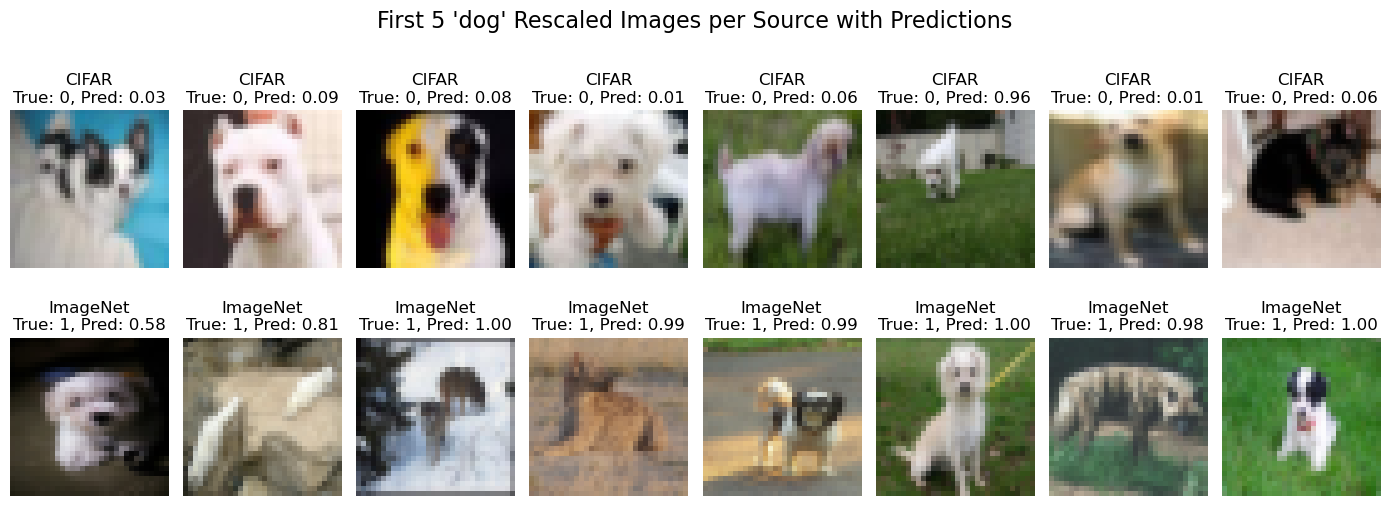

In [18]:
category = "dog"
picture_count = 8
start_idx_cifar = 8
start_idx_imagenet = 32
fig, axs = plt.subplots(2, picture_count, figsize=(14, 5))

# Filter sub-DataFrames
cifar_sub_df = from_DataFrame_get_subDataFrame_of_category(df_cifar, category)
imagenet_sub_df = from_DataFrame_get_subDataFrame_of_category(df_imagenet, category)

# Get images by index
cifar_images = test_gen.return_Img_by_Index(cifar_sub_df["index"][start_idx_cifar:picture_count+start_idx_cifar], rescaled=True)
imagenet_images = test_gen.return_Img_by_Index(imagenet_sub_df["index"][start_idx_imagenet:picture_count+start_idx_imagenet], rescaled=True)

# CIFAR-10 (top row)
for i in range(picture_count):
    img = cifar_images[i]
    row = cifar_sub_df.iloc[start_idx_cifar+i]
    title = f"CIFAR\nTrue: {int(row['y_true'])}, Pred: {row['rescaled_prediction']:.2f}"
    axs[0, i].imshow(img)
    axs[0, i].set_title(title)
    axs[0, i].axis("off")

# ImageNet (bottom row)
for i in range(picture_count):
    img = imagenet_images[i]
    row = imagenet_sub_df.iloc[start_idx_imagenet+i]
    title = f"ImageNet\nTrue: {int(row['y_true'])}, Pred: {row['rescaled_prediction']:.2f}"
    axs[1, i].imshow(img)
    axs[1, i].set_title(title)
    axs[1, i].axis("off")

plt.tight_layout()
plt.suptitle(f"First 5 '{category}' Rescaled Images per Source with Predictions", y=1.08, fontsize=16)
plt.show()

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 450)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,523 (5.95 KB)

 Trainable params: 507 (1.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,016 (3.97 KB)

In [20]:
def visualize_activations(model, image, max_filters=6):
    """
    Visualize intermediate activations after each layer for a single image.

    Parameters:
    - model: Trained Keras model
    - image: Numpy array of shape (32, 32, 3)
    - max_filters: How many filters to display per conv layer
    """
    # Show original image
    fig, axs = plt.subplots(1, 4, figsize=(4 * 2.5, 2.5))
    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    for i in range(3):
        axs[i+1].imshow(image[:,:,i])
        axs[i+1].set_title(f"Original Image Channel {i+1}")
        axs[i+1].axis('off')
    plt.tight_layout()
    plt.show()
    
    # Prepare image as batch input
    img_input = np.expand_dims(image, axis=0)

    # Get intermediate outputs
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.layers[0].input, outputs=layer_outputs)
    activations = activation_model.predict(img_input)

    # Visualize outputs
    for i, activation in enumerate(activations):
        if len(activation.shape) == 4:  # Conv/Pool layers: (1, H, W, C)
            num_filters = min(activation.shape[-1], max_filters)
            fig, axs = plt.subplots(1, num_filters, figsize=(num_filters * 2.5, 2.5))
            for j in range(num_filters):
                axs[j].imshow(activation[0, :, :, j], cmap='viridis')
                axs[j].axis('off')
                axs[j].set_title(f"Filter {j + 1}")
            plt.suptitle(f"Layer {i}: {model.layers[i].name} → shape {activation.shape[1:]}", fontsize=12)
            plt.tight_layout()
            plt.show()
        elif len(activation.shape) == 2:  # Dense layer: (1, N)
            print(f"Layer {i}: {model.layers[i].name} → Dense output shape: {activation.shape}")
            print(f"Output values (first 10): {activation[0][:36]}")


In [21]:
layer = model.layers[0] # layer.name returns 'conv2d'

# Extract weights from the Conv2D layer
kernels, biases = layer.get_weights()  # shape: (3, 3, 3, num_filters) for a 3x3 RGB kernel, num_filters filters
print("Kernel shape:", kernels.shape)
print(layer.input)

Kernel shape: (3, 3, 3, 2)
<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=False, ragged=False, name=input_layer>


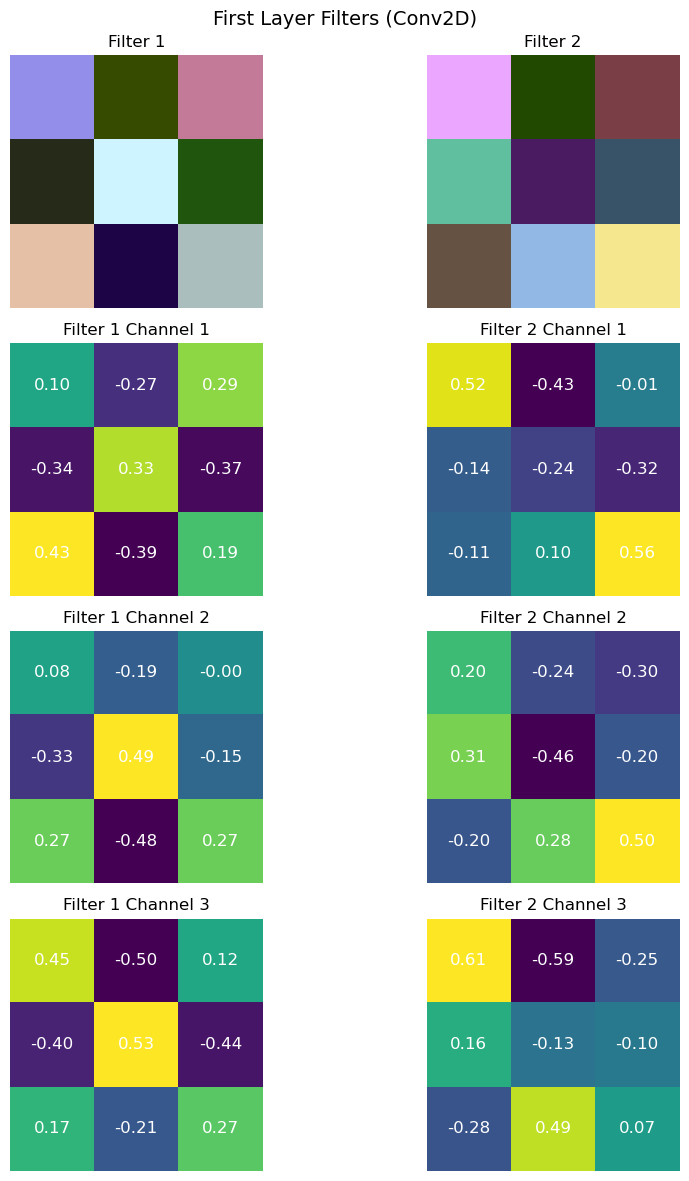

In [22]:
# Choose the first few filters
n_filters_to_show = np.min([5, kernels.shape[3]])
fig, axs = plt.subplots(4, n_filters_to_show, figsize=(5 * n_filters_to_show, 12))
axs = axs.flatten()

for i in range(n_filters_to_show):
    # Normalize for visualization
    kernel = kernels[:, :, :, i]
    kernel_min, kernel_max = kernel.min(), kernel.max()
    kernel_vis = (kernel - kernel_min) / (kernel_max - kernel_min)

    axs[i].imshow(kernel_vis)
    axs[i].set_title(f"Filter {i+1}")
    axs[i].axis('off')

    for j in range(3):
        kernel_channel_j = kernel[:,:,j]
        kernel_channel_j_min, kernel_channel_j_max = kernel_channel_j.min(), kernel_channel_j.max()
        kernel_vis_channel_j = (kernel_channel_j - kernel_channel_j_min) / (kernel_channel_j_max - kernel_channel_j_min)
        
        axs[i + n_filters_to_show * (j+1)].imshow(kernel_vis_channel_j)
        axs[i + n_filters_to_show * (j+1)].set_title(f"Filter {i+1} Channel {j+1}")
        axs[i + n_filters_to_show * (j+1)].axis('off')
        
        #for k in range(kernel_vis.shape[0]):
            #for z in range(kernel_vis.shape[1]):
               # axs[i + n_filters_to_show * (j+1)].text(z, k, f"{kernel_vis_channel_j[k, z]:.2f}",
                     #ha='center', va='center', color='white', fontsize=12)

        for k in range(kernel_vis.shape[0]):
            for z in range(kernel_vis.shape[1]):
                axs[i + n_filters_to_show * (j+1)].text(z, k, f"{kernel_channel_j[k, z]:.2f}",
                     ha='center', va='center', color='white', fontsize=12)

plt.suptitle("First Layer Filters (Conv2D)", fontsize=14)
plt.tight_layout()
plt.show()


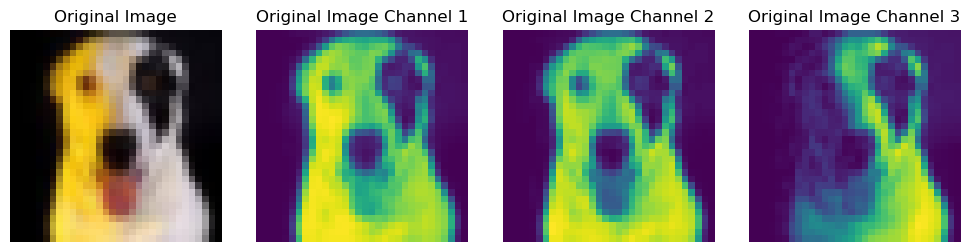

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


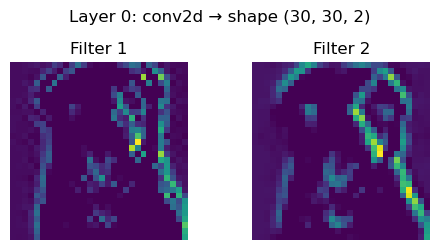

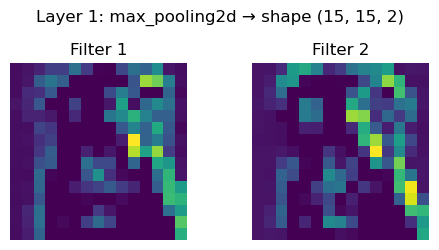

Layer 2: flatten → Dense output shape: (1, 450)
Output values (first 10): [0.00907758 0.05206677 0.01356275 0.05567379 0.02642085 0.12157133
 0.04933318 0.5459663  0.04920295 0.6060188  0.09749487 0.4445104
 0.04628804 0.1131198  0.00306275 0.1738762  0.0010817  0.3760066
 0.05771076 0.44820237 0.09806749 0.47614622 0.08316517 0.5620136
 0.12878223 0.04682771 0.01641207 0.06439775 0.00958255 0.06175804
 0.00907758 0.05206677 0.01614057 0.07985127 0.0782046  0.4878875 ]
Layer 3: dense → Dense output shape: (1, 1)
Output values (first 10): [0.08169722]


In [23]:
img = cifar_images[2]
visualize_activations(model, img, max_filters=5)

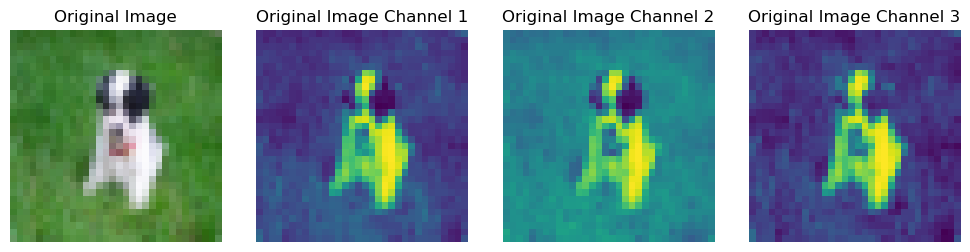

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


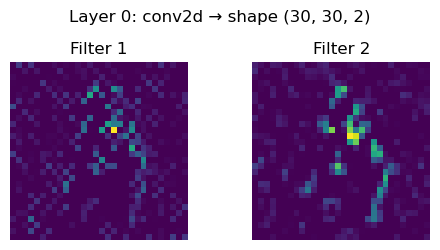

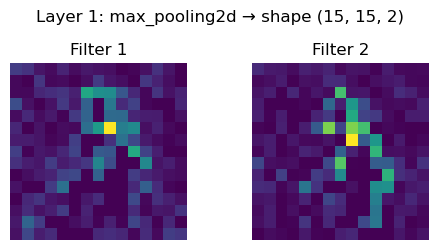

Layer 2: flatten → Dense output shape: (1, 450)
Output values (first 10): [0.07676901 0.14234518 0.06387196 0.08295208 0.02433218 0.07685144
 0.01198136 0.03905777 0.04360052 0.10489021 0.01468488 0.08097326
 0.0273156  0.11900463 0.02149882 0.030629   0.01765951 0.06311733
 0.00126564 0.05693086 0.00556967 0.01288014 0.02013521 0.08865301
 0.06273097 0.0288723  0.02409111 0.02661946 0.         0.02837828
 0.00948862 0.03098514 0.         0.04754384 0.0679924  0.08771637]
Layer 3: dense → Dense output shape: (1, 1)
Output values (first 10): [0.9981548]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


array([[0.9981548]], dtype=float32)

In [24]:
img = imagenet_images[-1]
visualize_activations(model, img, max_filters=5)
model.predict(np.expand_dims(img, axis=0))